In [17]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt


sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

plt.rc('axes', unicode_minus=False)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

In [18]:
# LOG_DIR = "../run-logs/logs-class,vessel,wildfire,multiclass-43200-1729158865" # 60deg experiment, 4h
LOG_DIR = "../run-logs/logs-class,vessel,wildfire,multiclass-21600-1729246624" # real log
# LOG_DIR = "../run-logs/logs-class,vessel,wildfire,multiclass,segment-21600-1729197477/"
MONITOR_LOG = os.path.join(LOG_DIR, "monitor-complete.log")
TFAAS_LOG = os.path.join(LOG_DIR, "tfaas-complete.log")

In [19]:
logs = []

inflight_logs = []

# log types we need
# temp -> C
# battery -> mWh
# solar -> mWh
# comms -> mWh
# rpi -> mWh
# sat -> mWh
# len(fq) -> int
# idle -> bool

with open(os.path.join(LOG_DIR, "monitor.log")) as f:
    for line in f:
        try:
            if "current temp" in line:
                s = line.strip().split()

                t = datetime.datetime.strptime(f"{s[1]} {s[2]}", "%Y/%m/%d %H:%M:%S.%f")
                logs.append({
                    "type": "temp_C",
                    "time": t,
                    "value": float(s[-1])
                })
            elif "outgoing (sat):" in line:
                # [monitor] 2024/10/17 08:12:57.245135 energy.go:105: solar: 11.463396mWh, outgoing (sat): 2.571056mWh, outgoing (RPi): 0.544663mWh, outgoing (comms): 0.000000mWh charge: 40258.402060mWh (70.014612%) elapsed 232312us

                s = line.strip().split()
                t = datetime.datetime.strptime(f"{s[1]} {s[2]}", "%Y/%m/%d %H:%M:%S.%f")

                elapsed_us = float(s[19][:-len("us")])

                logs.append({
                    "type": "battery_mWh",
                    "time": t,
                    "value": float(s[16][:-len("mWh")])
                })

                logs.append({
                    "type": "solar_mW",
                    "time": t,
                    "value": float(s[5][:-len("mWh,")]) * 3600 / (elapsed_us / 1e6)
                })

                logs.append({
                    "type": "comms_mW",
                    "time": t,
                    "value": float(s[14][:-len("mWh")]) * 3600 / (elapsed_us / 1e6)
                })

                logs.append({
                    "type": "rpi_mW",
                    "time": t,
                    "value": float(s[11][:-len("mWh,")]) * 3600 / (elapsed_us / 1e6)
                })

                logs.append({
                    "type": "sat_mW",
                    "time": t,
                    "value": float(s[8][:-len("mWh,")]) * 3600 / (elapsed_us / 1e6)
                })

                logs.append({
                    "type": "total_mW",
                    "time": t,
                    "value": (float(s[5][:-len("mWh,")]) - float(s[8][:-len("mWh,")])) * 3600 / (elapsed_us / 1e6)
                })

                # logs.append({
                #     "type": "elapsed_us",
                #     "time": t,
                #     "value": float(s[19][:len("us")])
                # })

        except Exception as e:
            print(e)
            print(line)
            break

with open(os.path.join(LOG_DIR, "tfaas.log")) as f:
    for line in f:
        try:
            if "len(fq)" in line:
                # [tf] 2024/10/17 08:12:37.629381 rproxy.go:277: state: busy, len(fq) == 0
                s = line.strip().split()

                t = datetime.datetime.strptime(f"{s[1]} {s[2]}", "%Y/%m/%d %H:%M:%S.%f")

                logs.append({
                    "type": "len_fq",
                    "time": t,
                    "value": int(s[8])
                })
                logs.append({
                    "type": "idle",
                    "time": t,
                    "value": s[5] == "idle,"
                })
            elif "inflight[" in line:

                # [tf] 2024/10/17 16:22:20.266393 rproxy.go:338: inflight[class] == 2
                s = line.strip().split()

                t = datetime.datetime.strptime(f"{s[1]} {s[2]}", "%Y/%m/%d %H:%M:%S.%f")

                f = s[4][len("inflight["):-len("]")]

                inflight_logs.append({
                    "time": t,
                    "func": f,
                    "value": int(s[6])
                })

        except Exception as e:
            print(e)
            print(line)
            break

df = pd.DataFrame(logs, columns=["time", "type", "value"])
df["reltime"] = (df["time"] - df["time"].min()).dt.total_seconds()

inflight_df = pd.DataFrame(inflight_logs, columns=["time", "func", "value"])
inflight_df["reltime"] = (inflight_df["time"] - df["time"].min()).dt.total_seconds()

In [20]:
df.head()

,time,type,value,reltime
0,2024-10-18 10:19:10.428226,battery_mWh,34500.051489,88.876505
1,2024-10-18 10:19:10.428226,solar_mW,40740.995929,88.876505
2,2024-10-18 10:19:10.428226,comms_mW,0.0,88.876505
3,2024-10-18 10:19:10.428226,rpi_mW,2849.107422,88.876505
4,2024-10-18 10:19:10.428226,sat_mW,8865.831506,88.876505


In [21]:
inflight_df.head()

,time,func,value,reltime
0,2024-10-18 10:31:54.252583,vessel,0,852.700862
1,2024-10-18 10:31:54.252639,wildfire,0,852.700918
2,2024-10-18 10:31:54.252667,multiclass,0,852.700946
3,2024-10-18 10:31:54.252693,class,0,852.700972
4,2024-10-18 10:31:54.252851,class,1,852.701130


/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_72637/2237345819.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_data["value"] = battery_data["value"]/BATTERY*100


Text(0.5, 0, 'Time (s)')

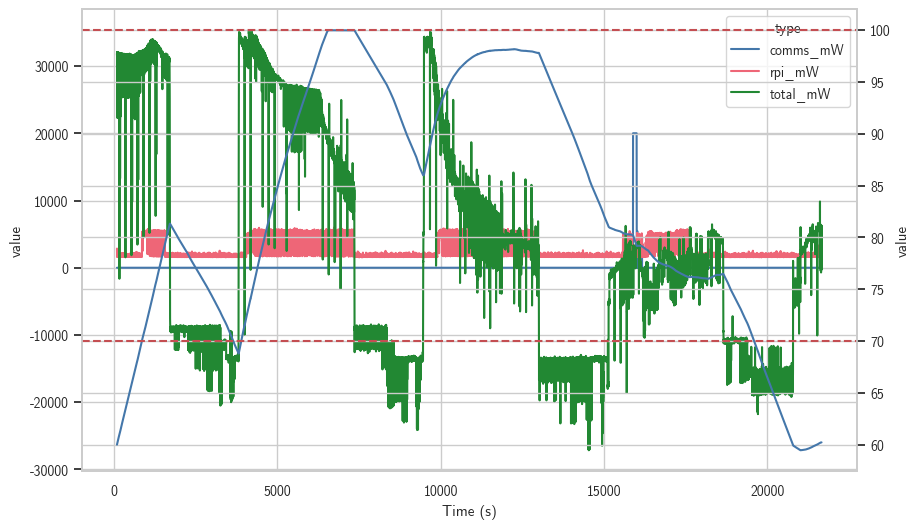

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
BATTERY = 57.5 * 1e3

energy_data = df[(df["type"] == "total_mW") | (df["type"] == "comms_mW") | (df["type"] == "rpi_mW")]
sns.lineplot(data=energy_data, x="reltime", y="value", ax=ax, hue="type")

battery_data = df[df["type"] == "battery_mWh"]
battery_data["value"] = battery_data["value"]/BATTERY*100

sns.lineplot(data=battery_data, x="reltime", y="value", ax=ax2)
ax2.axhline(y=100, color='r', linestyle='--')
ax2.axhline(y=70, color='r', linestyle='--')

# ax.legend(["Solar", "Comms", "RPi", "Sat"], loc='upper left')
ax.set_xlabel("Time (s)")

In [23]:
energy_data[(energy_data["type"] == "comms_mW") & (energy_data["value"] > 0)]

,time,type,value,reltime
108627,2024-10-18 14:42:32.882640,comms_mW,20000.007548,15891.330919
108634,2024-10-18 14:42:33.889353,comms_mW,20000.006357,15892.337632
108641,2024-10-18 14:42:34.897506,comms_mW,20000.011507,15893.345785
108648,2024-10-18 14:42:35.907104,comms_mW,20000.001585,15894.355383
108655,2024-10-18 14:42:36.919685,comms_mW,20000.0,15895.367964
...,...,...,...,...
110510,2024-10-18 14:47:05.100715,comms_mW,390.726384,16163.548994
110517,2024-10-18 14:47:06.107455,comms_mW,781.6375,16164.555734
110524,2024-10-18 14:47:07.114623,comms_mW,390.681382,16165.562902
110531,2024-10-18 14:47:08.121082,comms_mW,781.923307,16166.569361


Text(0.5, 0, 'Time (s)')

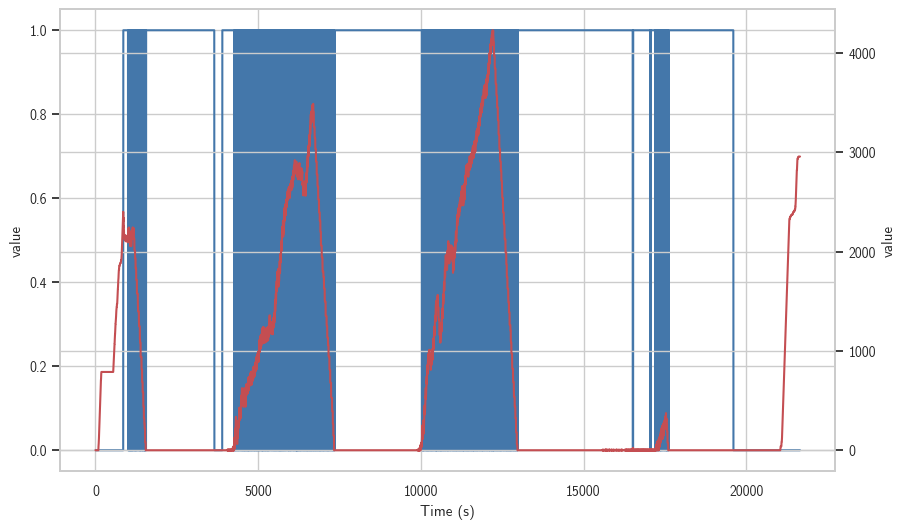

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

ax2 = ax.twinx()

sns.lineplot(data=df[df["type"] == "idle"], x="reltime", y="value", ax=ax)
sns.lineplot(data=df[df["type"] == "len_fq"], x="reltime", y="value", ax=ax2, color='r')
ax.set_xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

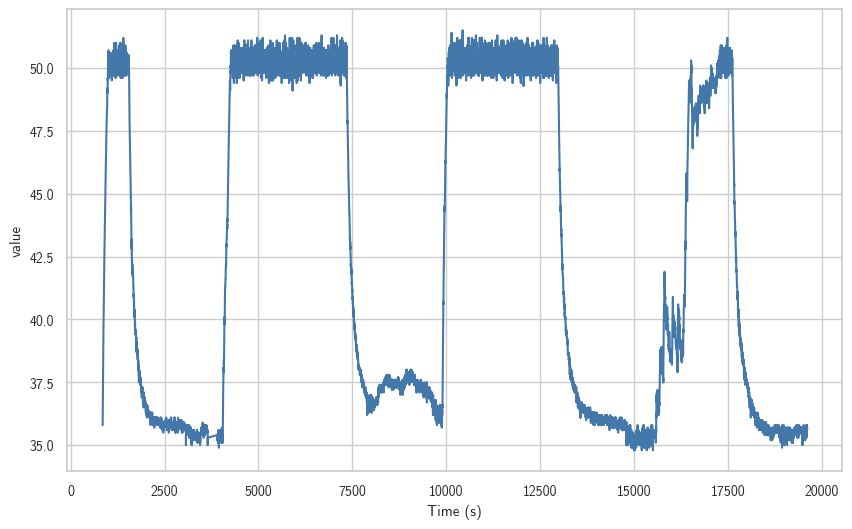

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=df[df["type"] == "temp_C"], x="reltime", y="value", ax=ax, estimator=None)
ax.set_xlabel("Time (s)")

In [26]:
df[df["type"] == "temp_C"].max()

time       2024-10-18 15:44:24.673112
type                           temp_C
value                            51.5
reltime                  19603.121391
dtype: object

webf NOT subset; don't know how to subset; dropped


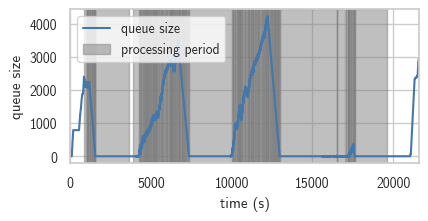

In [27]:
# First plot: idle periods and queue size

MAX_T = 21600

# get a list of idle periods
busy_periods = []
idle = True
for k, g in df[df["type"] == "idle"].iterrows():
    if not g["value"] == idle:
        busy_periods.append(g["reltime"])
        idle = not idle

len_fq = df[df["type"] == "len_fq"]
len_fq = len_fq[len_fq["reltime"] < MAX_T]
g = sns.lineplot(data=len_fq, x="reltime", y="value")

for bp in range(1, len(busy_periods), 2):
    # make a box
    start = busy_periods[bp]

    if start > MAX_T:
        break

    end = busy_periods[bp+1] if bp+1 < len(busy_periods) else MAX_T
    g.axvspan(start, end, color='gray', alpha=0.5)

g.set_xlabel("time (s)")
g.set_ylabel("queue size")

# add a legend
# g.legend(["Queue size", "Idle periods"], loc='upper left')
# fix patches in legend
handles, labels = g.get_legend_handles_labels()
# print(handles)
# print(labels)
# add a pal[0] line for queue size
handles.append(mpl.lines.Line2D([0], [0], color=pal[0]))
labels.append("queue size")
# the idle period patch should be gray
handles.append(mpl.patches.Patch(color='gray', alpha=0.5))
labels.append("processing period")
g.legend(handles=handles, labels=labels, loc='upper left')
g.set(xlim=(0, MAX_T))
plt.savefig("full-queue-size.pdf", bbox_inches='tight')

webf NOT subset; don't know how to subset; dropped


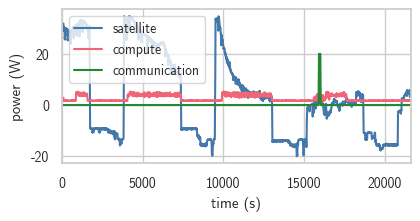

In [28]:
# second plot: power!
# comm power, pi power, and sat power
# energy_data = df[(df["type"] == "total_mWh") | (df["type"] == "comms_mWh") | (df["type"] == "rpi_mWh")]

# add some smoothing, maybe 20s?
smoothing = "20s"

local_df = df[df["reltime"] < MAX_T].copy()
local_df["value"] = local_df["value"] / 1000
total_data = local_df[local_df["type"] == "total_mW"].set_index("time").drop(columns=["type", "reltime"])
total_data = total_data.rolling(smoothing).mean().reset_index()
total_data["reltime"] = (total_data["time"] - local_df["time"].min()).dt.total_seconds()

comms_data = local_df[local_df["type"] == "comms_mW"].set_index("time").drop(columns=["type", "reltime"])
comms_data = comms_data.rolling(smoothing).mean().reset_index()
comms_data["reltime"] = (comms_data["time"] - local_df["time"].min()).dt.total_seconds()

rpi_data = local_df[local_df["type"] == "rpi_mW"].set_index("time").drop(columns=["type", "reltime"])
rpi_data = rpi_data.rolling(smoothing).mean().reset_index()
rpi_data["reltime"] = (rpi_data["time"] - local_df["time"].min()).dt.total_seconds()

# g = sns.lineplot(data=energy_data, x="reltime", y="value", hue="type")
g = sns.lineplot(data=total_data, x="reltime", y="value", color=pal[0])
sns.lineplot(data=rpi_data, x="reltime", y="value", color=pal[1], ax=g)
sns.lineplot(data=comms_data, x="reltime", y="value", color=pal[2], ax=g)

handles, labels = g.get_legend_handles_labels()
handles.append(mpl.lines.Line2D([0], [0], color=pal[0]))
labels.append("satellite")
handles.append(mpl.lines.Line2D([0], [0], color=pal[1]))
labels.append("compute")
handles.append(mpl.lines.Line2D([0], [0], color=pal[2]))
labels.append("communication")

g.legend(handles=handles, labels=labels, loc='upper left')

g.set_xlabel("time (s)")
g.set_ylabel("power (W)")
g.set(xlim=(0, MAX_T))
plt.savefig("full-power.pdf", bbox_inches='tight')

webf NOT subset; don't know how to subset; dropped


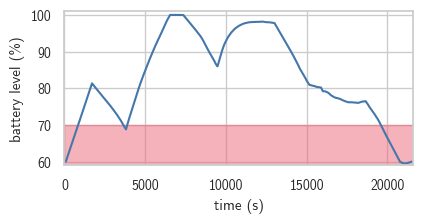

In [29]:
# third graph! battery level

local_df = df[df["reltime"] < MAX_T].copy()

BATTERY = 57.5 * 1e3
battery_data = local_df[local_df["type"] == "battery_mWh"].copy()
battery_data["value"] = battery_data["value"]/BATTERY*100

g = sns.lineplot(data=battery_data, x="reltime", y="value")

# add a red area below 70%
g.axhspan(0, 70, color=pal[1], alpha=0.5)
g.set(ylim=(59, 101))
g.set(xlim=(0, MAX_T))
plt.xlabel("time (s)")
plt.ylabel("battery level (%)")

plt.savefig("full-battery.pdf", bbox_inches='tight')

webf NOT subset; don't know how to subset; dropped


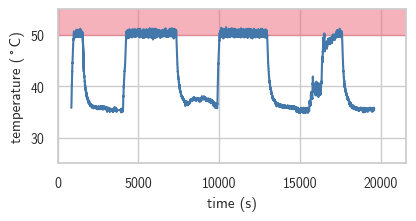

In [30]:
# fourth graph! temperature

local_df = df[df["reltime"] < MAX_T].copy()
local_df["value"] = local_df["value"]
temp_data = local_df[local_df["type"] == "temp_C"].set_index("time").drop(columns=["type", "reltime"])
temp_data = temp_data.rolling("1s").mean().reset_index()
temp_data["reltime"] = (temp_data["time"] - df["time"].min()).dt.total_seconds()

g = sns.lineplot(data=temp_data, x="reltime", y="value")

# add a red area above 50˚C

g.axhspan(50, 60, color=pal[1], alpha=0.5)
g.set(ylim=(25, 55))
g.set(xlim=(0, MAX_T))
plt.xlabel("time (s)")
plt.ylabel("temperature (˚C)")

plt.savefig("full-temp.pdf", bbox_inches='tight')

In [31]:
# stack the inflight df to get a total inflight count across all funcs
# but note that the time is slightly off
# build a new 1s index and use that to reindex the inflight df
s = pd.Series(pd.date_range(inflight_df["time"].min(), inflight_df["time"].max(), freq='1s'))
print(s.min())
print(s.max())
s = pd.DataFrame(s, columns=["time"])
print(s.head())

# stack the inflight frame to get a column for each unique func value
inflight_df_stacked = inflight_df.set_index(["time", "func"]).unstack().ffill().dropna()
# print(inflight_df_stacked.tail())
# inflight_df_stacked.columns = inflight_df_stacked.columns.droplevel(0)

# drop the reltime columns
inflight_df_stacked.drop(columns=["reltime"], inplace=True)

inflight_df_stacked.columns = [' '.join(col).strip() for col in inflight_df_stacked.columns.values]

inflight_df_stacked = inflight_df_stacked.reset_index(drop=False)
print(inflight_df_stacked.head())

print(inflight_df_stacked.dtypes)
print(s.dtypes)

inflight_df_s = pd.merge_asof(s, inflight_df_stacked, on="time", direction='forward')

print()
print(inflight_df_s.head())

inflight_df_s["total"] = inflight_df_s["value class"] + inflight_df_s["value vessel"] + inflight_df_s["value wildfire"] + inflight_df_s["value multiclass"]

inflight_df_s["reltime"] = (inflight_df_s["time"] - df["time"].min()).dt.total_seconds()
print(inflight_df_s.head())

2024-10-18 10:31:54.252583
2024-10-18 15:11:03.252583
                        time
0 2024-10-18 10:31:54.252583
1 2024-10-18 10:31:55.252583
2 2024-10-18 10:31:56.252583
3 2024-10-18 10:31:57.252583
4 2024-10-18 10:31:58.252583
                        time  value class  value multiclass  value vessel  \
0 2024-10-18 10:31:54.252693          0.0               0.0           0.0   
1 2024-10-18 10:31:54.252851          1.0               0.0           0.0   
2 2024-10-18 10:31:54.252895          1.0               0.0           0.0   
3 2024-10-18 10:31:54.252928          1.0               0.0           0.0   
4 2024-10-18 10:31:54.252957          1.0               0.0           0.0   

   value wildfire  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
time                datetime64[ns]
value class                float64
value multiclass           float64
value vessel               float64
value wildfire             float64
dtype: object


[(0.0, 21600.0)]

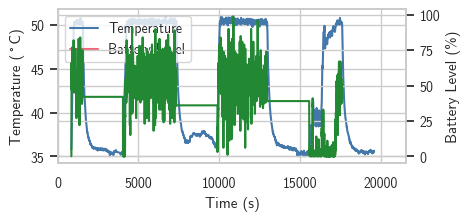

In [32]:
# third graph! battery level, temperature, and inflight

local_df = df[df["reltime"] < MAX_T].copy()
local_df["value"] = local_df["value"]
temp_data = local_df[local_df["type"] == "temp_C"].set_index("time").drop(columns=["type", "reltime"])
temp_data = temp_data.rolling(smoothing).mean().reset_index()
temp_data["reltime"] = (temp_data["time"] - df["time"].min()).dt.total_seconds()

BATTERY = 57.5 * 1e3
battery_data = local_df[local_df["type"] == "battery_mWh"].copy()
battery_data["value"] = battery_data["value"]/BATTERY*100

fig, ax = plt.subplots(figsize=(4.5, 2))
ax2 = ax.twinx()

sns.lineplot(data=temp_data, x="reltime", y="value", color=pal[0], ax=ax)
# sns.lineplot(data=battery_data, x="reltime", y="value", color=pal[1], ax=ax2)
sns.lineplot(data=inflight_df_s, x="reltime", y="total", ax=ax2, color=pal[2])

handles, labels = ax.get_legend_handles_labels()
handles.append(mpl.lines.Line2D([0], [0], color=pal[0]))
labels.append("Temperature")
handles.append(mpl.lines.Line2D([0], [0], color=pal[1]))
labels.append("Battery Level")

ax.legend(handles=handles, labels=labels, loc='upper left')

ax.set_xlabel("Time (s)")
ax.set_ylabel("Temperature (˚C)")
ax2.set_ylabel("Battery Level (%)")
ax.set(xlim=(0, MAX_T))